In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import pyplot
import math
from hodgkinhuxleyfunction import *

In [32]:
def hodgkinhuxley(state,t):
    v = state[0] # voltage state vector
    n = state[1] # activation variable for potassium channel state vector
    m = state[2] # activation variable for sodium channel state vector
    h = state[3] # inactivation variable for sodium channel state vector
    
    # Parameters
    R_a = 212.47 # (ohm-cm) axial resistance
    C_m = 0.77 # (µF/cm^2) membrane capacitance
    SA = 10,000 # (µm^2) total surface area (Gouwens reports 7343, 8308, and 10238 for dendrites)
    
    e_Na = 78 # (mV) nernst reversal potential of sodium current
    e_K = -30 # (mV) nernst reversal potential of potassium current (-80 in Gunay)
    e_L = -55 # (mV) nernst reversal potential of the leak current
    
    gbar_L = 0.0328 # (µS/cm^2) maximum leakage channel conductance
    gbar_Na = 108 # (µS/cm^2) maximum sodium channel conductance 
    g_Na = gbar_Na * h * m**3 # (µS/cm^2) sodium channel conductance
    gbar_K = 34 # (µS/cm^2) maximum potassium channel conductance 
    g_K = gbar_K * (n**4) # (µS/cm^2) potassium channel conductance
    
    I_Na = g_Na * (v-e_Na) # (µA) sodium current
    I_K = g_K * (v-e_K) # (µA) potassium current
    I_L = gbar_L # (µA) leak current
    I_app = 10 # (µA) applied current
    
    '''
    New parameters to consider from Gunay's (2015) paper
    I_Na_T = -29.13 # mA (transient Na+ current)
    g_Na_T = 100 nS (30 # mS/cm^2) (transient Na+ current conductance)
    I_Na_P = -48.77 # mA (persistent Na+ current)
    g_Na_P = 0.8 nS (0.1 # μS/cm^2) (persistent Na+ current conductance)
    I_K_s = -12.85 # mA (slow K+ current)
    g_Ks = 50 # nS (slow K+ current conductance)
    G_Ks = 30 # μS/cm^2 (slow K+ current channel density)
    I_K_f = -17.55 # mA (fast K+ current) 
    g_Kf = 24.1 # nS (fast K+ current conductance)
    
    Edited parameters from Marley's and Baines' (2011) paper
    I_Na_T = -24.1 +/- 2.7 # pA (transient Na+ current)
    g_Na_T = 100 # nS (transient Na+ current conductance)
    I_Na_P = -24.6 +/- 0.4 # pA (persistent Na+ current)
    g_Na_P = 0.8 # nS (persistent Na+ current conductance)
    I_K_s = 64.0 +/- 5.5 # pA (slow K+ current)
    g_K_s = 50 # nS (slow K+ current conductance)
    G_K_s = 30 # μS/cm2 (slow K+ current channel density)
    I_K_f = 84.1 +/- 5.9 # pA (fast K+ current) 
    g_K_f = 24.1 # nS (fast K+ current conductance)
    '''
    
    # Division is time constants (need units)
    
    # Channel Gating Kinetics for Potassium (K) channel n
    # n is the activation variable for the Potassium (K) Channel
    # Potassium channel does not inactivate, so there is no inactivation variable
    a_n = 0.01*(10-v)/(np.exp((10-v)/10)-1)
    b_n = 0.125*np.exp(-v/80)
    
    # Channel Gating Kinetics for Sodium (Na) Channel m
    # m is the activation variable for the Sodium (Na) Channel
    a_m = 0.1*(25-v)/(np.exp((25-v)/10)-1)
    b_m = 4*np.exp(-v/18)
    
    # Channel Gating Kinetics for Sodium (Na) Channel h
    # h is the inactivation variable for the Sodium (Na) Channel
    b_h = 1/(np.exp((30-v)/10)+1)    #should be +1?
    a_h = 0.07*np.exp(-v/20)
    
    # External current
    # step up 10 uA/cm^2 every 100ms for 400ms
    I_inj = 10*(t>100) - 10*(t>200) + 35*(t>300)
    #return 10*t
    
    # Differential Equations
    dvdt = (-I_Na - I_K - I_L + I_inj)/C_m
    dndt = a_n*(1-n) - b_n*n
    dmdt = a_m*(1-m) - b_m*m
    dhdt = a_h*(1-h) - b_h*h
    
    return dvdt, dndt, dmdt, dhdt

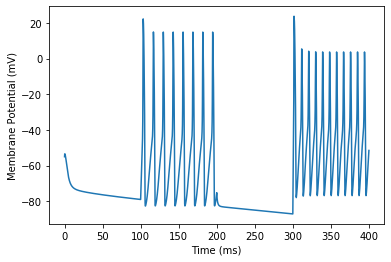

In [33]:
# Plot action potential response
t = np.arange(0,400,.001)
state0 = [0, 0.19, 0.18, 0.28]
state = odeint(hodgkinhuxley, state0, t)
plt.plot(t,state[:,0]-55)
pyplot.xlabel('Time (ms)')
pyplot.ylabel('Membrane Potential (mV)')
plt.show()

C:\Users\hudso\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


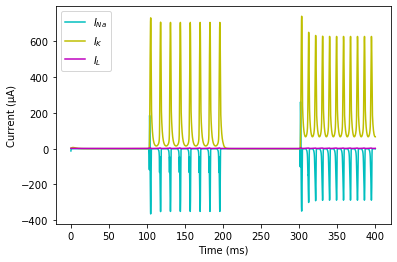

In [26]:
# Plot channel currents
gbar_Na = 108
g_Na = gbar_Na * state[:,3] * state[:,2]**3
# plt.plot(t, g_Na)
I_Na = g_Na * (state[:,0]-72)
plt.plot(t, I_Na, 'c', label='$I_{Na}$')

gbar_K = 34 # 
g_K = gbar_K * (state[:,1]**4) 
# plt.plot(t, g_K)
I_K = g_K * (+state[:,0]+68)
plt.plot(t, I_K, 'y', label='$I_{K}$')

gbar_L = 0.0328
I_L = gbar_L * (state[:,0]+55)
I_inj = 10*(t>100) - 10*(t>200) + 35*(t>300)
# plt.plot(t, gbar_L)
plt.plot(t, I_L, 'm', label = '$I_{L}$')

pyplot.xlabel('Time (ms)')
pyplot.ylabel('Current (μA)')

plt.legend()
plt.show()

C:\Users\hudso\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


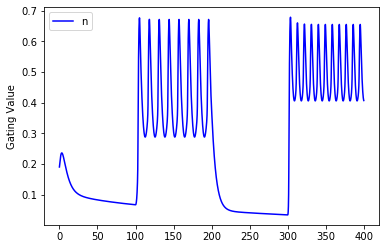

In [36]:
# Plot gating variables
# t = np.arange(0,20,.001)
plt.plot(t, state[:,1], 'b', label='n') # activation variable for K channel (n): blue
# plt.plot(t, state[:,2], 'r', label='m') # activation variable for Na channel (m): red
# plt.plot(t, state[:,3], 'g', label='h') # inactivation variable for Na channel (h): green
plt.ylabel('Gating Value')
plt.legend()

In [6]:
'''
Channel nernst reversal potentials
e_Na from 115 to 72: two spikes in 30 ms time span to 1; enough repolarization and ending potential at ~-65mV; peak at 
~10mV instead of 40mV; second round: increasing value increases membrane potential difference
e_K from -12 to -72: almost like a damped sine waveform; first repolarizes then follows in pattern and amplitude decreases; second
round: once the offset is changed, abnormal behavior at lower values (~ -30) and regular behavior at higher values (~ -70)
e_L from 10.6 to -60: no change

Sodium maximum channel conductance
gbar_Na from 120 to 0.4: severe decrease in change in membrane potential (~4mV); still looks like an action potential with 
sufficient depolarization and repolarization; second round: changes plateau at high values, abnormal behavior below 90
g_Na is function of gbar_Na, h, and m

Potassium maximum channel conductance
gbar_K from 36 to 0.37: regular change in membrane potential; sudden change at peak; doesn't repolarize enough - ends at 0mV;
second round: 
g_K is function of gbar_K and y

Leakage channel conductance
gbar_L from 0.3 to 0.0328: no change

Membrane capacitance
C_m from 1 to 0.77: no change

Channel currents
I_Na is function of g_Na, v, V_Na
I_K is function of g_K, v, V_K
I_L is function of g_L
I_app from 6.2 to 10: no change

state0 first term from 0 to 7: decrease in time span, slight increase in resting potential; as values increase more abnormal 
behavior
state0 second term: any small change results in different curves at peak any sizeable change results in abnormal damped 
behavior; slighly increased membrane potential at peak
state0 third term: decreases time span but makes peak slighly more of a sudden change
state0 fourth term: slight changes in peak shape; larger changes in membrane potential

Changed parameters (first round):
E_Na from 115 to 72
E_L from 10.6 to -60
gbar_L from 0.3 to 0.0328
C_m from 1 to 0.77
I_app from 6.2 to 10
n from 0.28 to 0.19
m from 0.05 to 0.18
h from 0.6 to 0.28

Changed parameters (second round):
E_Na from 72 to 48
E_K from -12 to -72
E_L from 10.6 to -60
gbar_L from 0.3 to 0.0328
gbar_Na from 
C_m from 1 to 0.77
I_app from 6.2 to 10
n from 0.28 to 0.19
m from 0.05 to 0.18
h from 0.6 to 0.28
'''

"\nChannel nernst reversal potentials\ne_Na from 115 to 72: two spikes in 30 ms time span to 1; enough repolarization and ending potential at ~-65mV; peak at \n~10mV instead of 40mV; second round: increasing value increases membrane potential difference\ne_K from -12 to -72: almost like a damped sine waveform; first repolarizes then follows in pattern and amplitude decreases; second\nround: once the offset is changed, abnormal behavior at lower values (~ -30) and regular behavior at higher values (~ -70)\ne_L from 10.6 to -60: no change\n\nSodium maximum channel conductance\ngbar_Na from 120 to 0.4: severe decrease in change in membrane potential (~4mV); still looks like an action potential with \nsufficient depolarization and repolarization; second round: changes plateau at high values, abnormal behavior below 90\ng_Na is function of gbar_Na, h, and m\n\nPotassium maximum channel conductance\ngbar_K from 36 to 0.37: regular change in membrane potential; sudden change at peak; doesn't 